<a href="https://colab.research.google.com/github/AikaHorizon333/pythonprojects/blob/main/04_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning 

We're going to go through the following with TensorFlow:

1. Introduce transfer learning (a way to beat all of our old self-built models)
2. Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
3. Build a transfer learning feature extraction model using TensorFlow Hub
4. Introduce the TensorBoard callback to track model training results
5. Compare model results using TensorBoard

In [ ]:
# Transfer Learning 

# Check for GPU

!nvidia-sim

/bin/bash: nvidia-sim: command not found


In [ ]:
# Importing the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-08 11:37:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   190MB/s    in 0.8s    

2022-07-08 11:37:15 (190 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

!ls





10_food_classes_10_percent	__MACOSX
10_food_classes_10_percent.zip	sample_data


In [ ]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 10 directori

In [ ]:
# Know we know that we have 10 classes, with 250 images to test per class and 
# 75 to train per class. 

# We save the directory's path for latter. 

test_dir = '10_food_classes_10_percent/test/'
train_dir = '10_food_classes_10_percent/train/'

In [ ]:
# Retrieve Class names

import pathlib
import random
import numpy as np


class_names = np.array(sorted([item.name for item in pathlib.Path(train_dir).glob('*')]))

class_names







array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def view_random_img(target_dir, target_class):
  

  PATH = target_dir+target_class

  img_random = random.sample(os.listdir(PATH),1)

  img = mpimg.imread(PATH+'/'+img_random[0])
  print(img.shape)
  plt.imshow(img)
  plt.title(target_class)

(512, 512, 3)


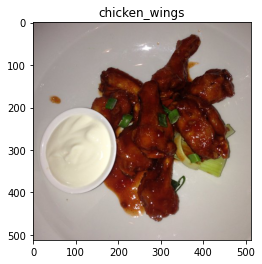

In [ ]:
view_random_img(target_dir=test_dir,
                target_class=random.choice(class_names))

In [ ]:
# Image Data Generator. 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale =1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training Images: ')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode = 'categorical')

print('Testing Images: ')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')



                                          


Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


In [ ]:
# Setting up callbacks
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name+'/'+ experiment_name + '/'+ datetime.datetime.now().strftime('%Y%m%d-%H%M$S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )

  print(f'Saving TensorBoard callback at: {log_dir}')
  return tensorboard_callback

In [ ]:
# Comparing 2 Models

import tensorflow_hub as hub
from tensorflow.keras import layers

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficient_net_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'



In [ ]:
# Function to load models from the hub. 


def create_model(model_url,num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.

    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  # Extract the features. 

  feature_extractor_layer = hub.KerasLayer(
      handle=model_url,
      trainable=False,
      name='feature_extractor_layer',
      input_shape =IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, 
                                            activation='softmax',
                                            name='output_layer')
  ])

  return model
                          

In [ ]:
# Model Creation
resnet_model = create_model(resnet_url)
efficient_net_model = create_model(efficient_net_url)


In [ ]:
# Compile the models
# Resnet Model 
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Efficient net

efficient_net_model.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
efficient_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
from gc import callbacks
history_resnet_1 = resnet_model.fit(train_data_10_percent,
                                    epochs=5,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=len(test_data),

                                    callbacks=[create_tensorboard_callback('TensorFlow_Hub','Resnet')])

Saving TensorBoard callback at: TensorFlow_Hub/Resnet/20220708-1142$S
Epoch 1/5
24/24 [==============================] - 32s 779ms/step - loss: 1.8305 - accuracy: 0.3853 - val_loss: 1.1910 - val_accuracy: 0.6164
Epoch 2/5
24/24 [==============================] - 16s 702ms/step - loss: 0.8749 - accuracy: 0.7573 - val_loss: 0.8578 - val_accuracy: 0.7324
Epoch 3/5
24/24 [==============================] - 17s 723ms/step - loss: 0.6051 - accuracy: 0.8307 - val_loss: 0.7647 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 17s 714ms/step - loss: 0.4735 - accuracy: 0.8707 - val_loss: 0.7194 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 16s 706ms/step - loss: 0.3798 - accuracy: 0.9027 - val_loss: 0.6877 - val_accuracy: 0.7756


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  history_df = pd.DataFrame(history.history)

  accuracy =  history_df['accuracy']
  val_accuracy = history_df['val_accuracy']
  loss = history_df['loss']
  val_loss = history_df['val_loss']

  epochs = np.arange(len(accuracy))

  plt.plot(epochs,accuracy, label='Training accuracy')
  plt.plot(epochs,val_accuracy, label='Train accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()

  
  plt.plot(epochs,loss, label = 'Training loss')
  plt.plot(epochs,val_loss, label = 'Test loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()



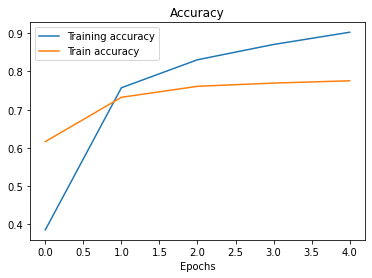

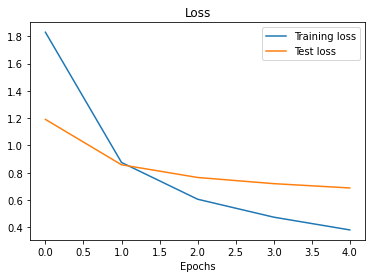

In [ ]:
plot_loss_curves(history_resnet_1)

In [ ]:
# Fitting the Efficient Net B0 

history_eNB0=efficient_net_model.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks=[create_tensorboard_callback('TensorFlow_Hub','efficient_net_b0')])

Saving TensorBoard callback at: TensorFlow_Hub/efficient_net_b0/20220708-1233$S
Epoch 1/5
24/24 [==============================] - 26s 981ms/step - loss: 0.4695 - accuracy: 0.8947 - val_loss: 0.5091 - val_accuracy: 0.8624
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.3726 - accuracy: 0.9280 - val_loss: 0.4731 - val_accuracy: 0.8696
Epoch 3/5
24/24 [==============================] - 16s 666ms/step - loss: 0.3176 - accuracy: 0.9400 - val_loss: 0.4507 - val_accuracy: 0.8724
Epoch 4/5
24/24 [==============================] - 16s 667ms/step - loss: 0.2731 - accuracy: 0.9560 - val_loss: 0.4348 - val_accuracy: 0.8736
Epoch 5/5
24/24 [==============================] - 16s 670ms/step - loss: 0.2396 - accuracy: 0.9627 - val_loss: 0.4239 - val_accuracy: 0.8744


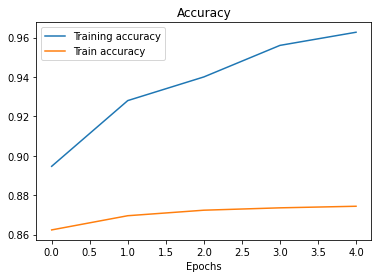

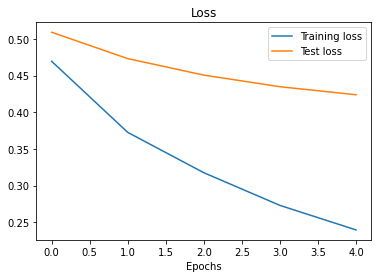

In [ ]:
plot_loss_curves(history_eNB0)

In [ ]:
# Uploading to TensorBoard. 

!tensorboard dev upload --logdir ./TensorFlow_Hub/ \
--name 'EfficientNetB0 vs ResNet50V2' \
--description 'Comparison between two architectures for Food Computer Vision Experiment on a 10% database' \
--one_shott

https://tensorboard.dev/experiment/zUgF4a7XRFyw4HXMfvvpkw/

In [ ]:
!tensorboard dev list


https://tensorboard.dev/experiment/zUgF4a7XRFyw4HXMfvvpkw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparison between two architectures for Food Computer Vision Experiment on a 10% database
	Id                   zUgF4a7XRFyw4HXMfvvpkw
	Created              2022-07-08 13:02:30 (33 minutes ago)
	Updated              2022-07-08 13:02:33 (33 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5792372
Total: 1 experiment(s)
